# Read and data cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# from utils.disease_name_mapping import dict_disease_name_mapping
# import utils.disease_name_mapping as dnm
# print(dir(dnm))
### READ DATA ###

df_raw = pd.read_csv('data/TCDCIntlEpidAll.csv')
country_mapping = pd.read_excel('data/03輔助用表_監測國家清單.xlsx')


### DATA CLEANING ###

df_raw["date"] = pd.to_datetime(df_raw['effective']).dt.date
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')

df_raw[['headline_country', 'headline_disease']] = df_raw['headline'].str.split(r'[-－─]', n=1, expand=True) 
    # either half-width - or full-width － or Box-drawing dash ─
df_raw['headline_country'] = df_raw['headline_country'].str.strip()
df_raw['headline_disease'] = df_raw['headline_disease'].str.strip()

df_raw = df_raw.drop(
    ["sent", "effective", "source", "expires", "senderName", "instruction", "web", "alert_title", "severity_level", "circle", "headline"], axis=1)

print(df_raw.head(2))

#disease name frequency
table_disease_freq = df_raw['headline_disease'].value_counts()
# print(table_disease_freq.head(5))

table_alert_disease_freq = df_raw['alert_disease'].value_counts() # alert disease is the original cell for the disease names which require lawful reporting
# print(table_alert_disease_freq.head(5))


                                         description   alert_disease  \
0  全球小兒麻痺根除倡議組織(GPEI)公布於5/8-14期間，cVDPV2型新增4國共9例，分...  小兒麻痺症/急性無力肢體麻痺   
1  美國於5/19累計15州報告26例病例，其中9例住院，經調查疑感染源為生產自佛羅里達州某廠商...         沙門氏菌感染症   

                                areaDesc  \
0  阿爾及利亞,布吉納法索,查德,象牙海岸,衣索比亞,巴基斯坦,索馬利亞,蘇丹   
1                                     美國   

                                         areaDesc_EN                  ISO3166  \
0  Algeria,Burkina Faso,Chad,Cote d'Ivoire,Ethiop...  DZ,BF,TD,CI,ET,PK,SO,SD   
1                                                USA                       US   

  areaDetail ISO3166_2       date headline_country headline_disease  
0        NaN       NaN 2025-05-23               全球            小兒麻痺症  
1        NaN       NaN 2025-05-23               美國     細菌性腸胃炎(沙門氏菌)  


### Country names mapping

In [2]:
#####
# (1) Build a mapping using 03輔助用表_監測國家清單.xlsx: each variation matches one ISO3
#####
variation_to_iso3 = {}

for idx, row in country_mapping.iterrows():
    iso3 = row['ISO3166-1三位代碼']
    if pd.isna(iso3):
        continue  # skip entries without ISO3

    variations = set() # Collect variations from different columns

    if pd.notna(row['監測國家/區域']):
        variations.add(str(row['監測國家/區域']).strip())
    if 'ISO3166-1(中文)' in row and pd.notna(row['ISO3166-1(中文)']):
        variations.add(str(row['ISO3166-1(中文)']).strip())
    if '外網國家別' in row and pd.notna(row['外網國家別']):
        variations.add(str(row['外網國家別']).strip())
    if '中文別稱' in row and pd.notna(row['中文別稱']):
        aliases = str(row['中文別稱']).split('|') # split by '|'
        variations.update([alias.strip() for alias in aliases])

    for var in variations:
        variation_to_iso3[var] = iso3

print(list(variation_to_iso3.items())[:20]) # items is dictionary method that returns a view object containing key-value pairs as tuples.

# Sort mapping by length of variation (descending): Longest variations are checked first, which can prevent confusion such as 馬利 in 索馬利亞
sorted_mapping = sorted(
    variation_to_iso3.items(),  # your dictionary of variation ➔ ISO3
    key=lambda x: len(x[0]),    # sort by length of variation string
    reverse=True                # longest first
)

# After extracting a matched variation, remove it from the text to "avoid re-matching shorter substrings" within it.
def extract_country_iso3_from_description(text, sorted_mapping):
    found_iso3 = set()  #Automatically remove duplicates if the same country is mentioned multiple times.
    if not isinstance(text, str):
        return None
    
    text_remaining = text
    for var, iso3 in sorted_mapping:
        if var in text_remaining:
            found_iso3.add(iso3)
            text_remaining = text_remaining.replace(var, '')# !  # Remove the matched variation from text_remaining to prevent further substring matches

    return list(found_iso3) if found_iso3 else None

# After extracting a matched variation, remove it from the text to "avoid re-matching shorter substrings" within it.
def extract_country_iso3_from_description(text, sorted_mapping):
    found_iso3 = set()#Automatically remove duplicates if the same country is mentioned multiple times.
    if not isinstance(text, str):
        return None

    text_remaining = text

    # Regex pattern to detect "CountryA 公布 CountryB", where the exclusion condition applies (Country A ≠ Country B)
    pattern_pub = re.compile(r'(\S+?)公布(\S+)')
    match = pattern_pub.search(text_remaining)

    excluded_country = None
    included_country = None
    if match:
        excluded_country = match.group(1).strip() 
        included_country = match.group(2).strip() 

    for var, iso3 in sorted_mapping:
        if var in text_remaining:
            if excluded_country and included_country and var == excluded_country and var != included_country:
                continue 

            found_iso3.add(iso3)
            text_remaining = text_remaining.replace(var, '')#!Remove the matched variation from text_remaining to prevent further substring matches

    return list(found_iso3) if found_iso3 else None

df_raw['description_iso3'] = df_raw['description'].apply(
    lambda x: extract_country_iso3_from_description(x, sorted_mapping))



#####
# (2) Screening the two-value code from ISO3166 to avoid loss of extration
#####

# transform iso2 to iso3
iso2_to_iso3 = {}
for idx, row in country_mapping.iterrows():
    iso2 = row['ISO3166-1二位代碼']
    iso3 = row['ISO3166-1三位代碼']
    if pd.notna(iso2) and pd.notna(iso3):
        iso2_to_iso3[str(iso2).strip()] = str(iso3).strip()

def convert_iso2_to_iso3(iso2_str, mapping_dict):
    if pd.isna(iso2_str):
        return None
    
    iso2_str = str(iso2_str).strip()
    
    iso2_list = [code.strip() for code in iso2_str.split(',')]# Split if multiple codes
    
    iso3_list = [mapping_dict.get(code) for code in iso2_list if mapping_dict.get(code)]
    
    return iso3_list if iso3_list else None

df_raw['ISO3166_to_3code'] = df_raw['ISO3166'].apply(lambda x: convert_iso2_to_iso3(x, iso2_to_iso3))

###
# (3) screening country names from headline
### 
headline_cn_to_iso3 = {}

for idx, row in country_mapping.iterrows():
    iso3 = row['ISO3166-1三位代碼']
    if pd.isna(iso3):
        continue
    # 全球/美洲/歐洲 will be None due to lack of iso3 code
    if pd.notna(row['中文別稱']):
        aliases = [alias.strip() for alias in str(row['中文別稱']).split('|')]
        for alias in aliases:
            headline_cn_to_iso3[alias] = iso3

def map_headline_country_to_iso3(headline_country_str, mapping_dict):
    if pd.isna(headline_country_str):
        return None
    countries = [c.strip() for c in str(headline_country_str).split('/')] #Splits the string by / to get individual countries.
    iso3_list = [mapping_dict.get(c) for c in countries if mapping_dict.get(c)]
    return iso3_list if iso3_list else None

df_raw['headline_country_iso3'] = df_raw['headline_country'].apply(
    lambda x: map_headline_country_to_iso3(x, headline_cn_to_iso3) )

###
# (4) create consolidated country_iso3 by set (description_iso3 and ISO3166_to_3code and headline_country_iso3 )
###
def combine_iso_codes(iso2_3code, description, headline):
    combined_set = set()    
    if isinstance(iso2_3code, list):
        combined_set.update(iso2_3code)
    elif pd.notna(iso2_3code): 
        combined_set.add(iso2_3code)
    
    if isinstance(description, list):
        combined_set.update(description)
    
    if isinstance(headline, list):
        combined_set.update(headline)
    
    return list(combined_set) if combined_set else None

df_raw['country_iso3'] = df_raw.apply(
    lambda row: combine_iso_codes(row['ISO3166_to_3code'], 
                                  row['description_iso3'],
                                  row['headline_country_iso3']),
    axis=1
)

print(df_raw[['ISO3166','ISO3166_to_3code', 'description_iso3', 'headline_country_iso3','country_iso3']].head(10))


[('南極洲', 'ATA'), ('阿富汗', 'AFG'), ('阿爾巴尼亞', 'ALB'), ('阿爾及利亞', 'DZA'), ('美屬薩摩亞', 'ASM'), ('美屬薩摩亞(美屬)', 'ASM'), ('安道爾', 'AND'), ('安哥拉', 'AGO'), ('安吉拉(英屬)', 'AIA'), ('安吉拉', 'AIA'), ('安吉拉(英國海外領地)', 'AIA'), ('安地卡及巴布達', 'ATG'), ('阿根廷', 'ARG'), ('亞美尼亞', 'ARM'), ('阿魯巴(荷屬)', 'ABW'), ('阿魯巴', 'ABW'), ('荷屬阿魯巴', 'ABW'), ('澳洲', 'AUS'), ('澳大利亞', 'AUS'), ('奧地利', 'AUT')]
                   ISO3166                          ISO3166_to_3code  \
0  DZ,BF,TD,CI,ET,PK,SO,SD  [DZA, BFA, TCD, CIV, ETH, PAK, SOM, SDN]   
1                       US                                     [USA]   
2           CN,HK,JP,KR,SG                 [CHN, HKG, JPN, KOR, SGP]   
3                       IN                                     [IND]   
4                    BO,US                                [BOL, USA]   
5                       JP                                     [JPN]   
6                       JP                                     [JPN]   
7              CA,MX,UA,US                      [CAN, MEX, UKR, USA]

In [3]:
# Checks for substring confusion only between different ISO3 codes,

# confusion_list = []

# # Build a list of all variations with their ISO3 code
# variation_iso3_pairs = []

# for idx, row in country_mapping.iterrows():
#     iso3 = row['ISO3166-1三位代碼']
#     if pd.isna(iso3):
#         continue

#     # Process 中文別稱 column
#     if pd.notna(row['中文別稱']):
#         aliases = [alias.strip() for alias in str(row['中文別稱']).split('|')]
#         for alias in aliases:
#             variation_iso3_pairs.append( (alias, iso3) )

# # Check for substring confusion among 中文別稱 variations across different ISO3 codes
# for i, (var1, iso3_1) in enumerate(variation_iso3_pairs):
#     for j, (var2, iso3_2) in enumerate(variation_iso3_pairs):
#         if (
#             i != j 
#             and iso3_1 != iso3_2  # Only between different ISO3 codes
#             and var1 in var2
#         ):
#             confusion_list.append( (var1, var2, iso3_1, iso3_2) )

# # Display potential confusion pairs
# for c in confusion_list:
#     print(f"Alias '{c[0]}' (ISO3: {c[2]}) is substring of '{c[1]}' (ISO3: {c[3]})")


In [4]:
# assess difference 
df_diff = df_raw[
    df_raw.apply(
        lambda row: set(row['ISO3166_to_3code'] or []) != set(row['description_iso3'] or []),
        axis=1
    )
]

# Display result
print(df_diff[['description','ISO3166_to_3code', 'description_iso3', 'country_iso3']].head(10))

# there is all NA
# df_na = df_diff[df_diff['country_iso3'].isna()]
# print(df_na[['description', 'ISO3166_to_3code', 'description_iso3', 'country_iso3']].head(10))


                                          description  \
9     \r獅子山疫情持續上升，自5/9-16單週新增611例病例，高於前1週483例，為IIb...   
12  中南美洲近年病例數上升，巴拿馬/哥斯大黎加/加拉瓜/宏都拉斯/瓜地馬拉/薩爾瓦多/墨西哥等國...   
13  法屬馬約特島疫情上升，自3/5於該島東北部發現首例輸入病例後，截至5/4累計報告116例病例...   
16  捷克5/16報告1例病例，疑伊波拉病毒感染症/馬堡病毒出血熱，病患為41歲美國籍男性個案，近...   
17  本週摘要：  \r人類疫情：本週孟加拉新增1例H5N1流感、中國新增8例H9N2流感及1例H...   
26    \r摩洛哥自2023年10月爆發疫情以來，截至今年4/13全國共12個地區報告2.5萬餘...   
32  法屬留旺島疫情持續，近1週(4/28-5/4)報告3,079例病例，今年迄今累計逾47,50...   
36  本週摘要：  \r人類疫情：本週無新增人類感染病例。 \r禽/動物疫情(WAHIS)： \r...   
47  剛果民主共和國北基伍省爆發疫情，截至5/2累計16例疑及1例確診病例，其中1例死亡，主要發生...   
48  納米比亞疫情更新，自去年底迄3/23累計逾30,000例病例及60餘例死亡，致死率為0.2%...   

                            ISO3166_to_3code  \
9                                 [SLE, TGO]   
12  [CAN, CRI, SLV, GTM, HND, MEX, NIC, PAN]   
13                                [MYT, REU]   
16                                     [CZE]   
17                                [BGD, CHN]   
26                 [AUS, CAN, MEX, MAR, USA]   
32                                  

### Disease name mapping

In [5]:
## Disease Name Mapping: for main name, sub name
# def clean_heading_disease_name(name):
#     name = re.sub(r'\(.*?\)', '', name)     # 移除括號內的內容
#     name = re.sub(r'^\d+', '', name)    # 去除數字開頭
#     return name.strip()

# df_raw['headline_disease'] = df_raw['headline_disease'].apply(clean_heading_disease_name)

# import sys
# sys.path.append('/utils/disease_name_mapping')

# import my_script

# %run  01_disease_name_mapping.py


dict_disease_name_mapping = { #multiple diseases are splitted by /
    '新型冠狀病毒肺炎': 'COVID-19',  #old name: new name
    '嚴重特殊傳染性肺炎': 'COVID-19',
    "新型冠狀肺炎": "COVID-19", # n=1
    #"新型冠狀病毒": "COVID-19", This is MERS
    "新冠併發重症(每週更新)": 'COVID-19',
    "新冠併發重症(本週更新)": "COVID-19", 
    '新冠併發重症': 'COVID-19',
    "猴痘": "M痘",
    "M痘(每月更新)": "M痘",
    "M痘(每週更新)": "M痘",
    "M痘(本週更新)": "M痘",
    "新型A型流感(每週更新)": "新型A型流感",
    '新型A型流感(本週更新)': "新型A型流感",
    '新型A型流感(H3N2v)': "新型A型流感",
    '新型A型流感(H9N2)' : "新型A型流感",
    "新型A型流感(H9N2/H10N3)": "新型A型流感",
    "新型A型流感(H5N1)": "新型A型流感",
    #"新型A型流感(哺乳動物感染禽流感)": "新型A型流感",
    "新型A型流感(H5)": "新型A型流感",
    'H7N9流感': '新型A型流感',
    "H5N1流感": "新型A型流感",
    "H3N8流感": "新型A型流感",
    "H3N1v流感": "新型A型流感",
    "H3N2v流感": "新型A型流感",
    "H5流感":  "新型A型流感",
    "H1N2v流感": "新型A型流感",
    "H5N6流感": "新型A型流感",
    "H9N2流感": "新型A型流感",
    "H3N1v流感": "新型A型流感",
    "H1N2v流感病例": "新型A型流感",
    "H1v流感":  "新型A型流感",
    'H3N2v流感': "新型A型流感",
    'H3N2v、H1N2v流感': "新型A型流感",
    "H1N1v流感": "新型A型流感",
    "H1N2流感": "新型A型流感",
    "H5N8流感": "新型A型流感",
    "H10N3流感" : "新型A型流感",
    "H1N1流感": "新型A型流感",
    "H1N1新型流感": "新型A型流感",
    "─H7N9流感": "新型A型流感",
    "Echovirus 30 (E30)": "腸病毒",
    '1腸道菌感染症': '腸道菌感染症',
    # "病毒性腸胃炎(諾羅病毒)": "",
    "病毒性腸胃炎(沙門氏菌)": "沙門氏菌感染症",
    "沙門氏菌感染": "沙門氏菌感染症",
    "抗藥性沙門氏菌": "沙門氏菌感染症",
    "沙門氏菌": "沙門氏菌感染症",
    "沙門氏菌(Salmonella Agbeni)": "沙門氏菌感染症",
    "細菌性腸胃炎(沙門氏菌)": "沙門氏菌感染症",
    "細菌性腸胃炎(曲狀桿菌/沙門氏菌)": "細菌性腸胃炎(曲狀桿菌)/沙門氏菌感染症",
    "曲狀桿菌": "細菌性腸胃炎(曲狀桿菌)",
    "多重抗藥性曲狀桿菌": "細菌性腸胃炎(曲狀桿菌)",
    "不明原因腹瀉": "腹瀉", # pending
    "不明原因疾病死亡": "不明原因致死疾病",
    "不明原因死亡": "不明原因致死疾病",
    "不明原因致死疾病(疑似炭疽病)": "不明原因致死疾病",
    "不明原因疾病(急性腹瀉與嘔吐)": "不明原因疾病",
    "不明原因肺炎": "不明原因疾病",
    "不明原因神經系統疾病":"不明原因疾病",
    '不明原因腦脊髓膜炎': "不明原因疾病",
    "不明原因出血": "不明原因疾病",
    "不明原因疾病(番茄流感)":  "不明原因疾病",
    "不明原因出血疾病": "不明原因疾病", 
    "不明原因急性肝炎": "不明原因疾病",
    "不明蟲媒發熱疾病": "不明原因疾病",
    "不明原因腦炎與細菌性腦膜炎": "不明原因疾病",
    "不明原因腦膜炎": "不明原因疾病",
    "不明原因急性腎衰竭": "不明原因疾病",
    "不明原因肝炎": "不明原因疾病",
    "不明原因急性腎衰竭": "不明原因疾病",
    "不明原因呼吸道疾病": "不明原因疾病",
    "不明原因腦膜炎": "不明原因疾病",
    "兒童急性嚴重不明原因肝炎": "不明原因疾病",
    "不明原因呼吸道疾病": "不明原因疾病",
    "不明原因肺炎": "不明原因疾病",
    "不明蟲媒發熱疾病": "不明原因疾病",
    "不明原因腦炎": "不明原因疾病",
    "兒童急性嚴重不明原因肝炎": "不明原因疾病",
    "人類免疫缺乏病毒感染": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV感染": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV/AIDS": "人類免疫缺乏病毒(愛滋病毒)感染",
    "愛滋病": "人類免疫缺乏病毒(愛滋病毒)感染",
    "梅毒與先天性梅毒": "梅毒/先天性梅毒",
    "猩紅熱與侵襲性A群鏈球菌感染": "猩紅熱與A群鏈球菌感染",
    "猩紅熱與侵襲性A群鏈球菌感染症": "猩紅熱與A群鏈球菌感染",
    "猩紅熱及侵襲性A型鏈球菌感染": "猩紅熱與A群鏈球菌感染",
    "溶血性A群鏈球菌感染": "A群鏈球菌感染",
    "侵襲性A群鏈球菌": "A群鏈球菌感染",
    "克里米亞剛果出血熱": "克里米亞-剛果出血熱",
    "克里米-亞剛果出血熱": "克里米亞-剛果出血熱",
    "立百病毒": "立百病毒感染症",
    "立百病毒感染": "立百病毒感染症",
    "漢他病毒": "漢他病毒症後群",
    "漢他病毒感染症": "漢他病毒症後群",
    "漢他病毒出血熱": "漢他病毒症後群",
    "漢他病毒肺症候群": "漢他病毒症後群",
    "皮膚利什曼原蟲症" : "利什曼原蟲症", 
    "萊姆病、蜱媒腦炎": "萊姆病/蜱媒腦炎",
    "E型肝炎": "急性病毒性E型肝炎",
    "A型肝炎": "急性病毒性A型肝炎",
    "中東呼吸症候群冠狀病毒": "中東呼吸症候群冠狀病毒感染症",
    "發熱伴血小板減少綜合症(SFTS)":"發熱伴血小板減少綜合症",
    "傳染性紅斑": "傳染性紅斑症",
    "人類間質肺炎病毒(HMPV)": "人類間質肺炎病毒感染",
    "人類間質肺炎": "人類間質肺炎病毒感染",
    "人類間質肺炎病毒": "人類間質肺炎病毒感染",
    "伊波拉病毒": "伊波拉病毒感染", # Sudan病毒疾病是伊波拉病毒感染的一種
    "剛果出血熱死": "剛果出血熱",
    "急性無力脊髓炎(Acute Flaccid Myelitis, AFM)": "急性無力脊髓炎",
    "巴利症候群": "格林巴利症候群",
    "巴利症候群(GBS)": "格林巴利症候群",
    "茲卡病毒": "茲卡病毒感染",
    "Zika病毒": "茲卡病毒感染",
    "5腸道菌感染症": "腸道菌感染症",
    "4腸道菌感染症": "腸道菌感染症",
    "西尼羅病毒": "西尼羅熱",
    "李斯特菌": "李斯特菌症",
    "1綠膿桿菌感染症": "綠膿桿菌感染症",




    #中國大陸-法定傳染病  包含多種傳染病 香港 巴西
    #人畜共通傳染病'
    #"人類免疫缺乏病毒(愛滋病毒)感染"
    # 食媒性傳染病
    # 流感疫苗
    # 性傳染病
    #呼吸道傳染病
}

df_raw['disease_name_unlist'] = df_raw['headline_disease'].map(dict_disease_name_mapping).fillna(df_raw['headline_disease'])

df_raw['disease_name'] = df_raw['disease_name_unlist'].apply(
    lambda x: [d.strip() for d in str(x).split('/')] if pd.notna(x) else None)

print(df_raw['disease_name'].value_counts().reset_index().head(50))
# print((df_raw['disease_name'].dropna().unique()))

          disease_name  count
0                [登革熱]   2261
1             [新型A型流感]   2040
2              [禽類禽流感]   1507
3                 [麻疹]   1433
4           [COVID-19]    936
5                 [霍亂]    901
6                [腸病毒]    846
7              [小兒麻痺症]    725
8                 [流感]    642
9            [茲卡病毒感染症]    637
10           [伊波拉病毒感染]    559
11    [中東呼吸症候群冠狀病毒感染症]    515
12               [屈公病]    438
13           [沙門氏菌感染症]    427
14                [瘧疾]    365
15               [狂犬病]    340
16                [M痘]    301
17               [黃熱病]    294
18              [大腸桿菌]    252
19               [百日咳]    247
20              [西尼羅熱]    237
21               [炭疽病]    230
22         [急性病毒性A型肝炎]    216
23             [退伍軍人病]    213
24          [流行性腦脊髓膜炎]    201
25               [拉薩熱]    200
26              [諾羅病毒]    199
27            [不明原因疾病]    198
28                [鼠疫]    171
29  [人類免疫缺乏病毒(愛滋病毒)感染]    166
30        [克里米亞-剛果出血熱]    161
31             [法定傳染病]    157
32        

### Consolidated dataframe "df": explode by country and disease

In [6]:
# selecting meaningful variables
df_temp = df_raw[["date","country_iso3","disease_name","description"]].copy()

df_expanded = df_temp.explode('country_iso3').reset_index(drop=True)

# Mapping back a eng and mandarin full names - must be done after exploding iso3
country_name_map_zh = dict(zip(country_mapping['ISO3166-1三位代碼'], country_mapping['監測國家/區域']))
country_name_map_en = dict(zip(country_mapping['ISO3166-1三位代碼'], country_mapping['監測國家/區域(英文)']))

df_expanded['country_name_zh'] = df_expanded['country_iso3'].map(country_name_map_zh)
df_expanded['country_name_en'] = df_expanded['country_iso3'].map(country_name_map_en)

df = df_expanded.explode('disease_name').reset_index(drop=True)

# a comnbined column: country with disease
df['country_disease'] = df.apply(
    lambda row: f"{row['country_name_zh']}_{row['disease_name']}" # combined with "_"
    if pd.notna(row['country_name_zh']) and pd.notna(row['disease_name'])
    else None,
    axis=1)

print(df.head(15))

         date country_iso3 disease_name  \
0  2025-05-23          PAK        小兒麻痺症   
1  2025-05-23          SDN        小兒麻痺症   
2  2025-05-23          DZA        小兒麻痺症   
3  2025-05-23          TCD        小兒麻痺症   
4  2025-05-23          BFA        小兒麻痺症   
5  2025-05-23          CIV        小兒麻痺症   
6  2025-05-23          ETH        小兒麻痺症   
7  2025-05-23          SOM        小兒麻痺症   
8  2025-05-23          USA      沙門氏菌感染症   
9  2025-05-23          HKG          腸病毒   
10 2025-05-23          KOR          腸病毒   
11 2025-05-23          SGP          腸病毒   
12 2025-05-23          CHN          腸病毒   
13 2025-05-23          JPN          腸病毒   
14 2025-05-23          IND       不明原因疾病   

                                          description country_name_zh  \
0   全球小兒麻痺根除倡議組織(GPEI)公布於5/8-14期間，cVDPV2型新增4國共9例，分...            巴基斯坦   
1   全球小兒麻痺根除倡議組織(GPEI)公布於5/8-14期間，cVDPV2型新增4國共9例，分...              蘇丹   
2   全球小兒麻痺根除倡議組織(GPEI)公布於5/8-14期間，cVDPV2型新增4國共9例，分...           阿爾及利亞   
3   全球小兒麻痺根除倡議組織(GP

### List of top n diseases

In [12]:
list_common_diseases = df['disease_name'].value_counts().head(20).index

print(list_common_diseases)

df_common = df[df['disease_name'].isin(list_common_diseases)].copy()

#print(df_common)

#print(df_raw[df_raw['headline_disease'].isnull()])

Index(['新型A型流感', 'COVID-19', '登革熱', '小兒麻痺症', '麻疹', '流感', '禽類禽流感', 'M痘', '霍亂',
       '伊波拉病毒感染', '腸病毒', '茲卡病毒感染症', '不明原因疾病', '屈公病', '沙門氏菌感染症',
       '中東呼吸症候群冠狀病毒感染症', '瘧疾', '黃熱病', '狂犬病', '西尼羅熱'],
      dtype='object', name='disease_name')


#  Diseases Visualisations

### Disease stacked area chart

In [308]:
print(df["disease_name"].unique())

['小兒麻痺症' '沙門氏菌感染症' '腸病毒' '不明原因疾病' '漢他病毒症候群' '傳染性紅斑症' '百日咳' '麻疹' '狂犬病' 'M痘'
 '類鼻疽' '拉薩熱' '蠅蛆症' '屈公病' '奧羅普切熱' '瘧疾' '新型A型流感' 'COVID-19' '小兒麻痺'
 '急性病毒性A型肝炎' '李斯特菌症' '流行性腦脊髓膜炎' '梅毒' '炭疽病' '登革熱' '黃熱病' '立百病毒感染症' '霍亂' '流感'
 '克里米亞-剛果出血熱' '伊波拉病毒感染(蘇丹病毒疾病)' '利什曼原蟲症' '傷寒' '猩紅熱' '先天性梅毒' '兔熱病'
 '病毒性腸胃炎(諾羅病毒)' '細菌性腸胃炎(曲狀桿菌)' '茲卡病毒感染症' '侵襲性肺炎鏈球菌感染症' '人類免疫缺乏病毒(愛滋病毒)感染'
 '布氏桿菌病' '不明原因致死疾病' '結核病' '墨累河谷腦炎' '食媒性傳染病' '福氏內格里阿米巴腦膜炎' '馬堡病毒出血熱' '日本腦炎'
 '流感疫苗' '漢生病' '性傳染病' '不明原因出血熱' '腸道出血性大腸桿菌感染症' '白喉' '肺炎黴漿菌感染症' None '桿菌性痢疾'
 '羅斯河病毒感染' '呼吸道傳染病' '創傷弧菌' '腸病毒感染併發重症' '流行性腮腺炎' '伊波拉病毒感染' '蘇丹病毒疾病(SVD)'
 '疥瘡感染症' '水痘' '人類間質肺炎病毒感染' '退伍軍人病' 'XCV感染' '第二型豬鏈球菌感染症' '鸚鵡熱' '創傷弧菌感染'
 '細小病毒B19感染' '剛果民主共和國' '福氏內格里阿米巴腦膜腦炎' '西尼羅熱' '細菌性腦膜炎' '鉤端螺旋體病' '萊姆病'
 '食物中毒' '急性病毒性B型肝炎' '腸道寄生蟲病' '猩紅熱與A群鏈球菌感染' '球黴菌症' '恙蟲病' 'Yezo病毒(YEZV)感染'
 '鬚癬毛癬菌VII型感染' '急性無力肢體麻痺' '美國' '東部馬腦炎' '新型A型流感(哺乳動物感染禽流感)' '鼠傳E型肝炎'
 '細菌性腸胃炎' '急性無力脊髓炎' '血吸蟲症' 'Q熱' '球黴菌溪谷熱' '肉毒桿菌中毒' '章地埔拉病毒感染' '旋毛蟲感染症'
 '阿根廷出血熱' 'Ｍ痘' '淋病' '鉤端螺旋體' '波瓦桑病毒' '急性病毒性E型肝炎' '阿米巴腦膜炎' '豬鏈球菌感染症' '棘狀阿米

<Figure size 1200x600 with 0 Axes>

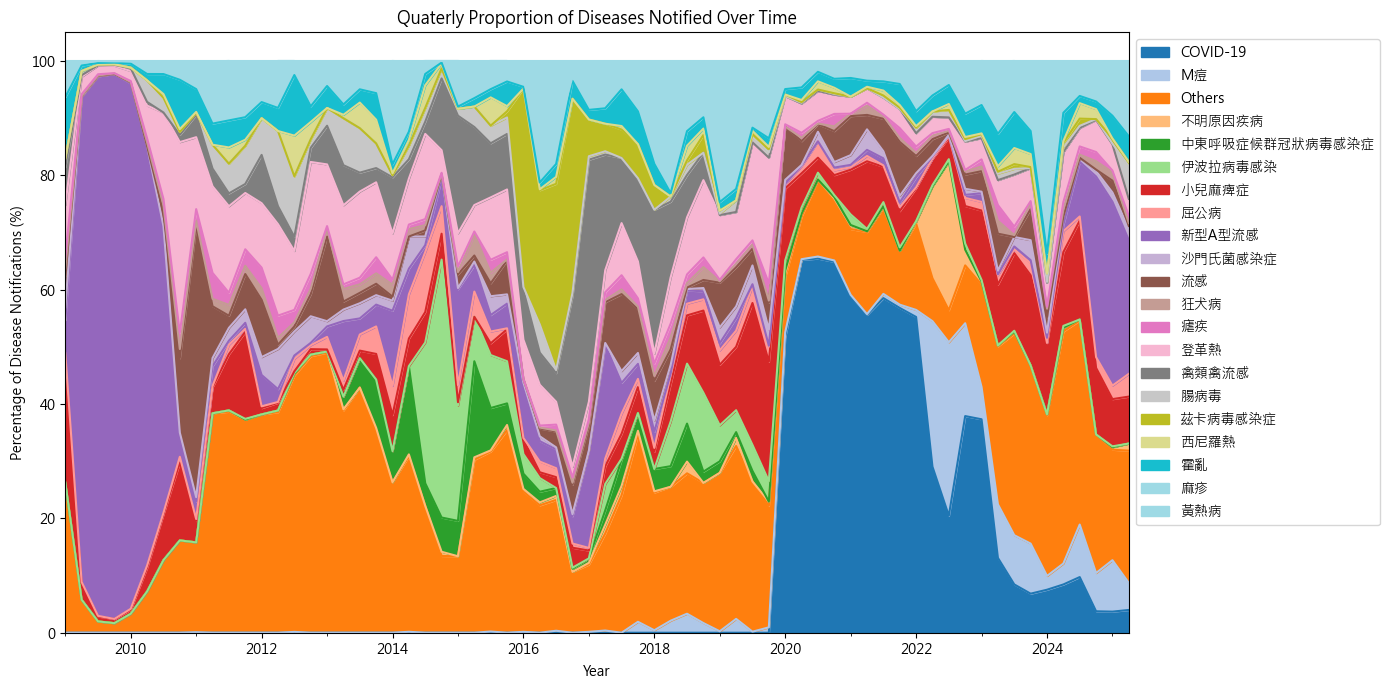

In [309]:
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.family'] = 'Microsoft JhengHei'

plt.rcParams['axes.unicode_minus'] = False

# 🟢 Step 1: Categorize diseases not in list_common_diseases as 'other'
df_plot = df.copy()
df_plot['disease_grouped'] = df_plot['disease_name'].apply(
    lambda x: x if x in list_common_diseases else 'Others'
)

# 🟢 Step 2: Group by month and grouped disease name
df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Q'), 'disease_grouped'])# Y Q M
    .size()
    .reset_index(name='count')
)

# Convert Period to Timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

# 🟢 Step 3: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='disease_grouped', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# 🟢 Step 4: Plot stacked area chart
plt.figure(figsize=(12, 6))
df_percent.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab20')
plt.ylabel('Percentage of Disease Notifications (%)')
plt.title('Quaterly Proportion of Diseases Notified Over Time')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Top 5 disease name heatmap

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_24020\1851928969.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, 4 - row), 1, 1, color=color, edgecolor='black'))


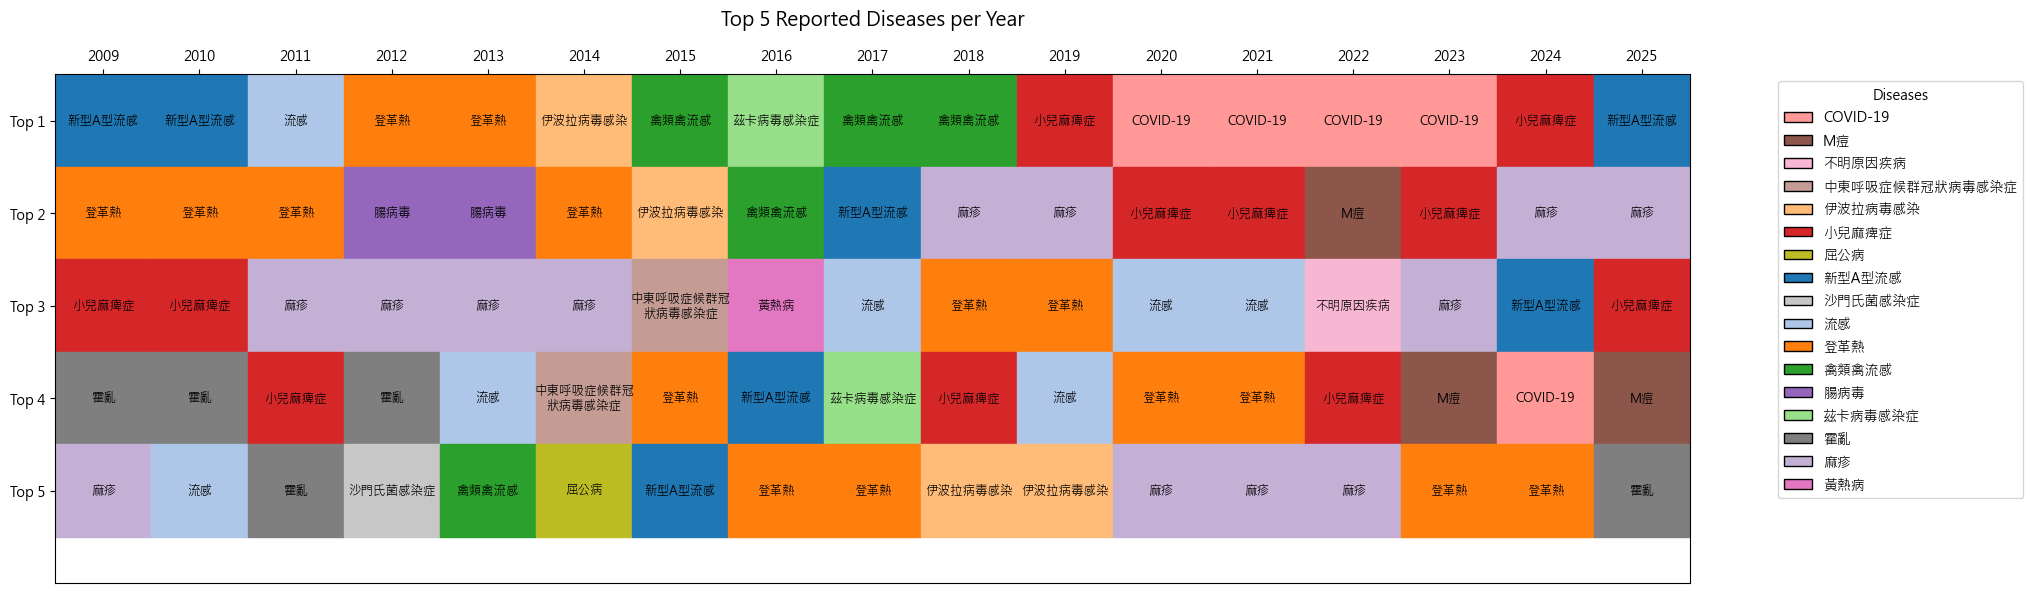

In [310]:
# Top N disease name

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap
# 🟢 Step 1–4: Same as before
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['year'] = df_plot['date'].dt.year

df_counts = (
    df_plot
    .groupby(['year', 'disease_name'])
    .size()
    .reset_index(name='count')
)

top5_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(5)
)

ranked = (
    top5_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['disease_name']
    .apply(list)
    .reset_index()
)
years = ranked['year'].tolist()
disease_table = pd.DataFrame([r + [None] * (5 - len(r)) for r in ranked['disease_name']], index=years).T

# 🟢 Assign unique color
all_diseases = pd.unique(disease_table.values.ravel())
color_map = dict(zip(all_diseases, plt.cm.tab20.colors[:len(all_diseases)]))

# 🟢 Step 5: Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.2, 6))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, 5)


# Draw cells
for col, year in enumerate(years):
    for row in range(5):
        disease = disease_table.iloc[row, col]
        color = color_map.get(disease, 'lightgray')
        ax.add_patch(plt.Rectangle((col, 4 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(disease, width=8)) if disease else ''
        ax.text(col + 0.5, 4 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# 🟢 Step 6: Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')  # move x-axis label to top
ax.xaxis.tick_top()

# 🟢 Step 6.5: Left Y-axis for "Top 1" to "Top 5"
ax.set_yticks([i + 0.5 for i in range(5)])
ax.set_yticklabels([f"Top {i+1}" for i in range(5)][::-1], fontsize=10)

# 🟢 Step 7: Legend
legend_elements = [
    Patch(facecolor=color_map[d], edgecolor='black', label=d)
    for d in sorted(color_map) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title("Top 5 Reported Diseases per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()



### Report histogram

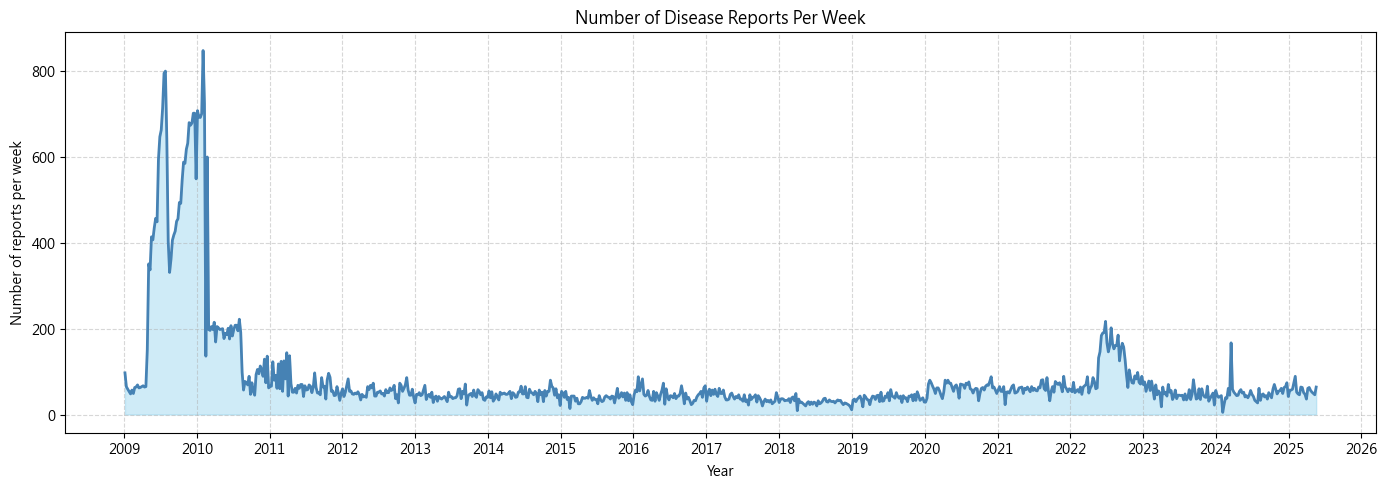

In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 🟢 Step 1: Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# 🟢 Step 2: Create a new 'week' column that represents the start of each week
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 3: Group by week and count number of reports per week
df_weekly_counts = df.groupby('week').size().reset_index(name='count')

# 🟢 Step 4: Plot the weekly report count as a bar chart
plt.figure(figsize=(14, 5))
plt.plot(df_weekly_counts['week'], df_weekly_counts['count'], linestyle='-', color='steelblue', linewidth=2)
plt.fill_between(df_weekly_counts['week'], df_weekly_counts['count'], color='skyblue', alpha=0.4)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)
ax.set_yticks([])

plt.title('Number of Disease Reports Per Week')
plt.xlabel('Year')
plt.ylabel('Number of reports per week')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Bubble plot by disease

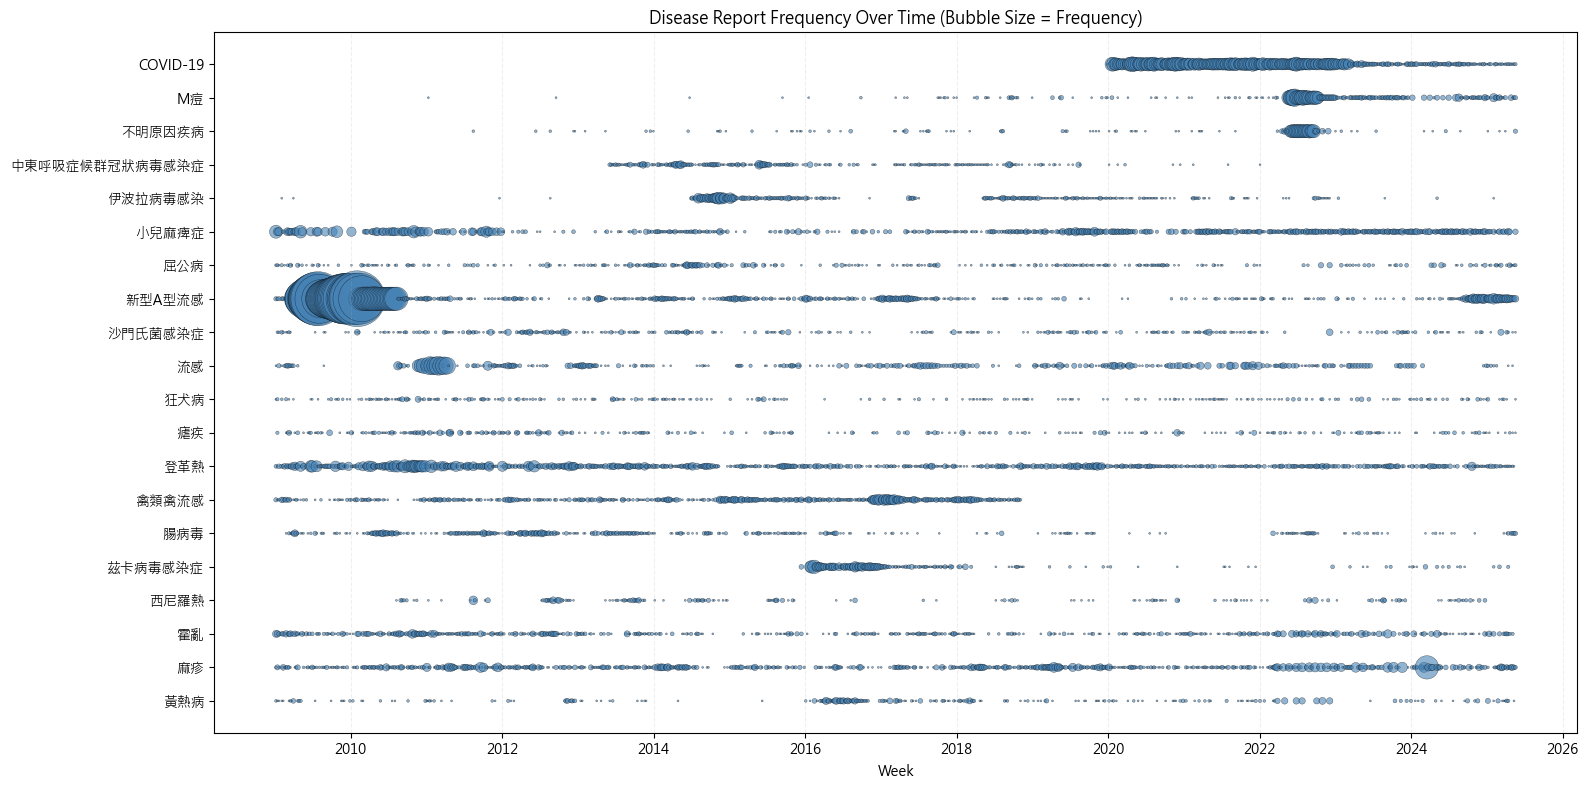

In [312]:
import pandas as pd
import matplotlib.pyplot as plt

# 🟢 Step 1: Prepare data
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# 🟢 Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# 🟢 Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(16, len(disease_list) * 0.4))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# 🟢 Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show() 


### Bubble plot for PHEIC diseases

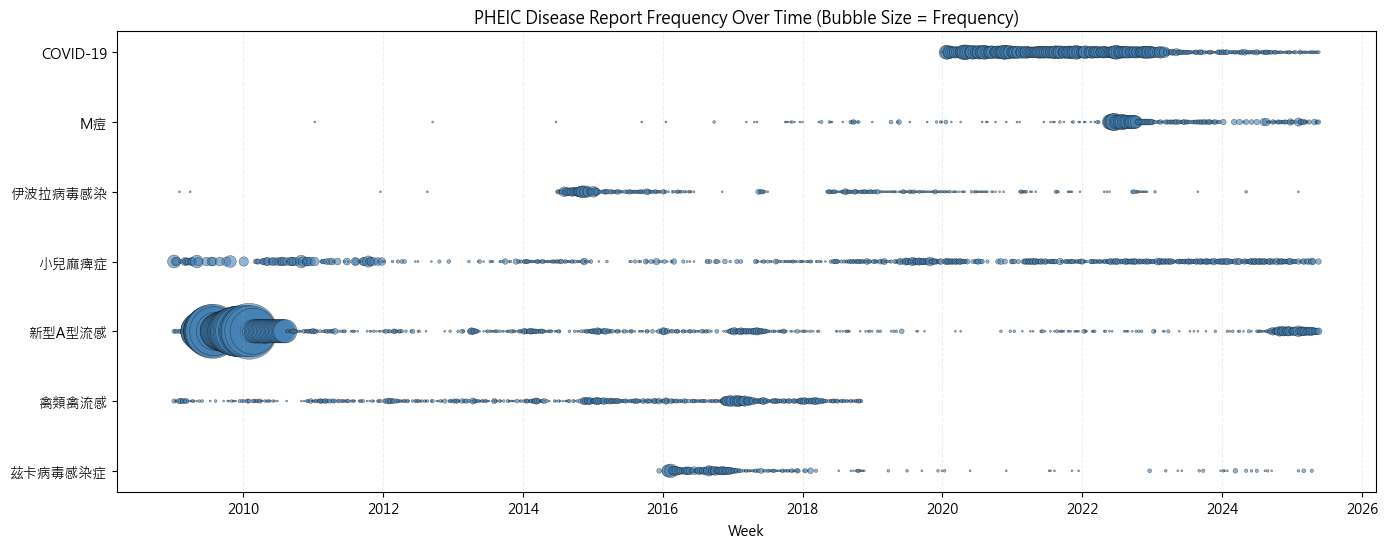

In [313]:
# only PHEIC diseases
import pandas as pd
import matplotlib.pyplot as plt


list_PHEIC_diseases = ["COVID-19","新型A型流感","禽類禽流感","小兒麻痺症","伊波拉病毒感染","M痘","茲卡病毒感染症"]


df_plot = df[df['disease_name'].isin(list_PHEIC_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# 🟢 Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# 🟢 Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(14, len(disease_list) * 0.8))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# 🟢 Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("PHEIC Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


# Country visualisations

### Top ten countries

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_24020\2206951059.py:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))


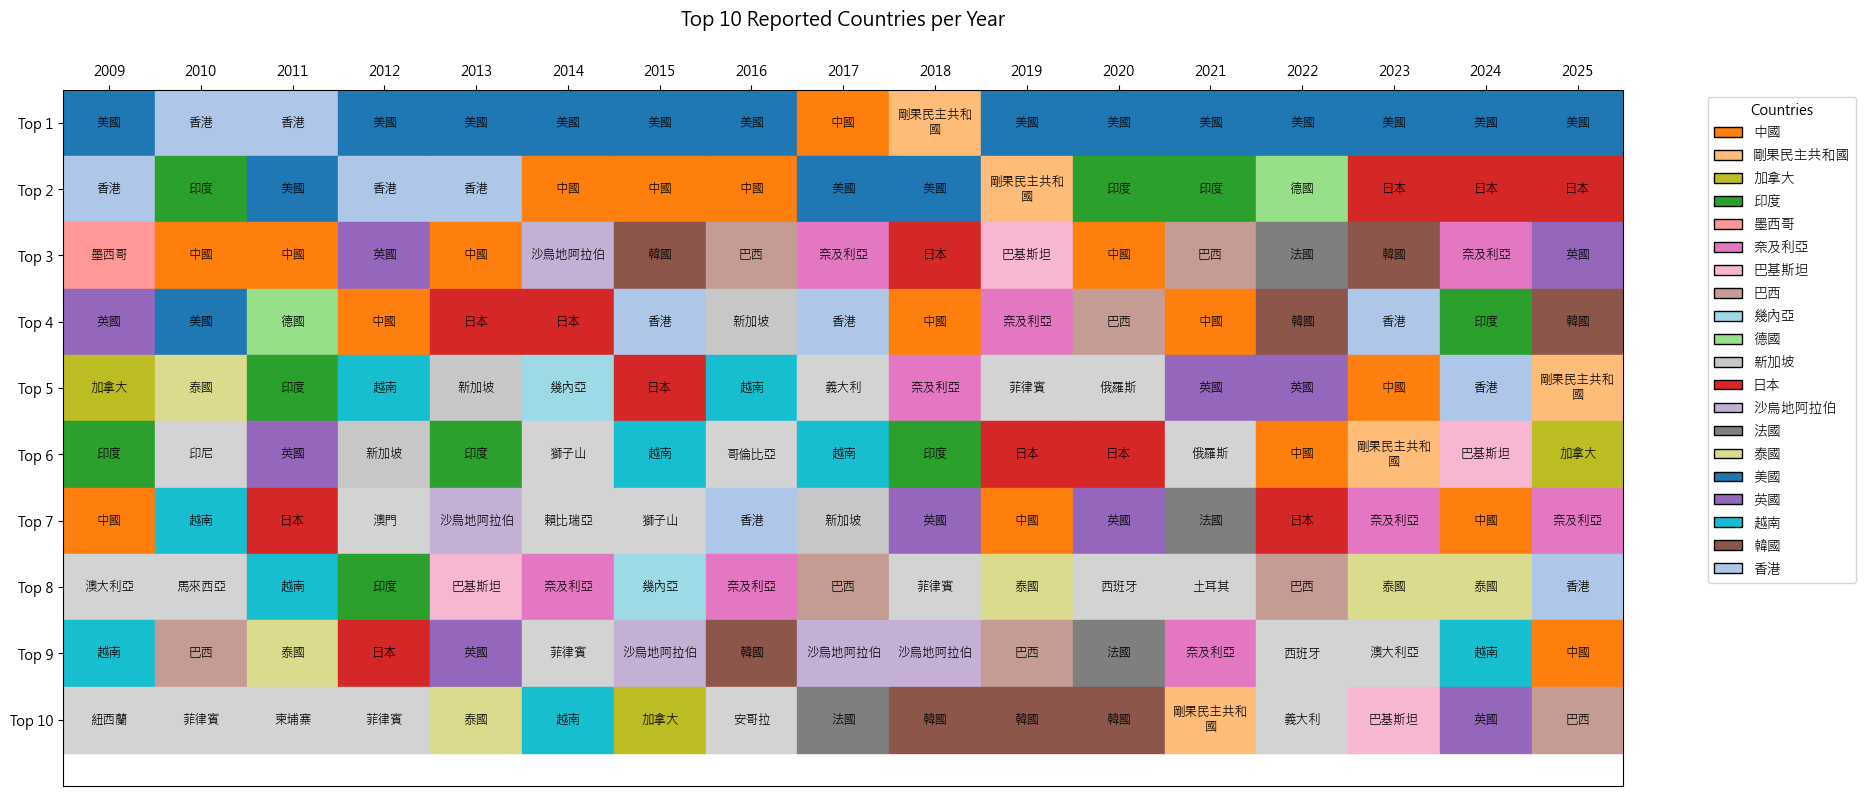

In [314]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap

n_top_countries = 10

# 🟢 Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

df_counts = (
    df_plot
    .groupby(['year', 'country_name_zh'])
    .size()
    .reset_index(name='count')
)

top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# 🟢 Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_name_zh']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_name_zh']],
    index=years
).T

# 🟢 Assign unique colors
all_countries = pd.unique(country_table.values.ravel())
color_map = dict(zip(all_countries, plt.cm.tab20.colors[:len(all_countries)]))

# 🟢 Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country = country_table.iloc[row, col]
        color = color_map.get(country, 'lightgray')
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country, width=6)) if country else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# Legend
legend_elements = [
    Patch(facecolor=color_map[c], edgecolor='black', label=c)
    for c in sorted(color_map) if c is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Countries")

plt.title(f"Top {n_top_countries} Reported Countries per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()

In [315]:
### Top regions

### Top N country_disease

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_24020\821595555.py:74: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))


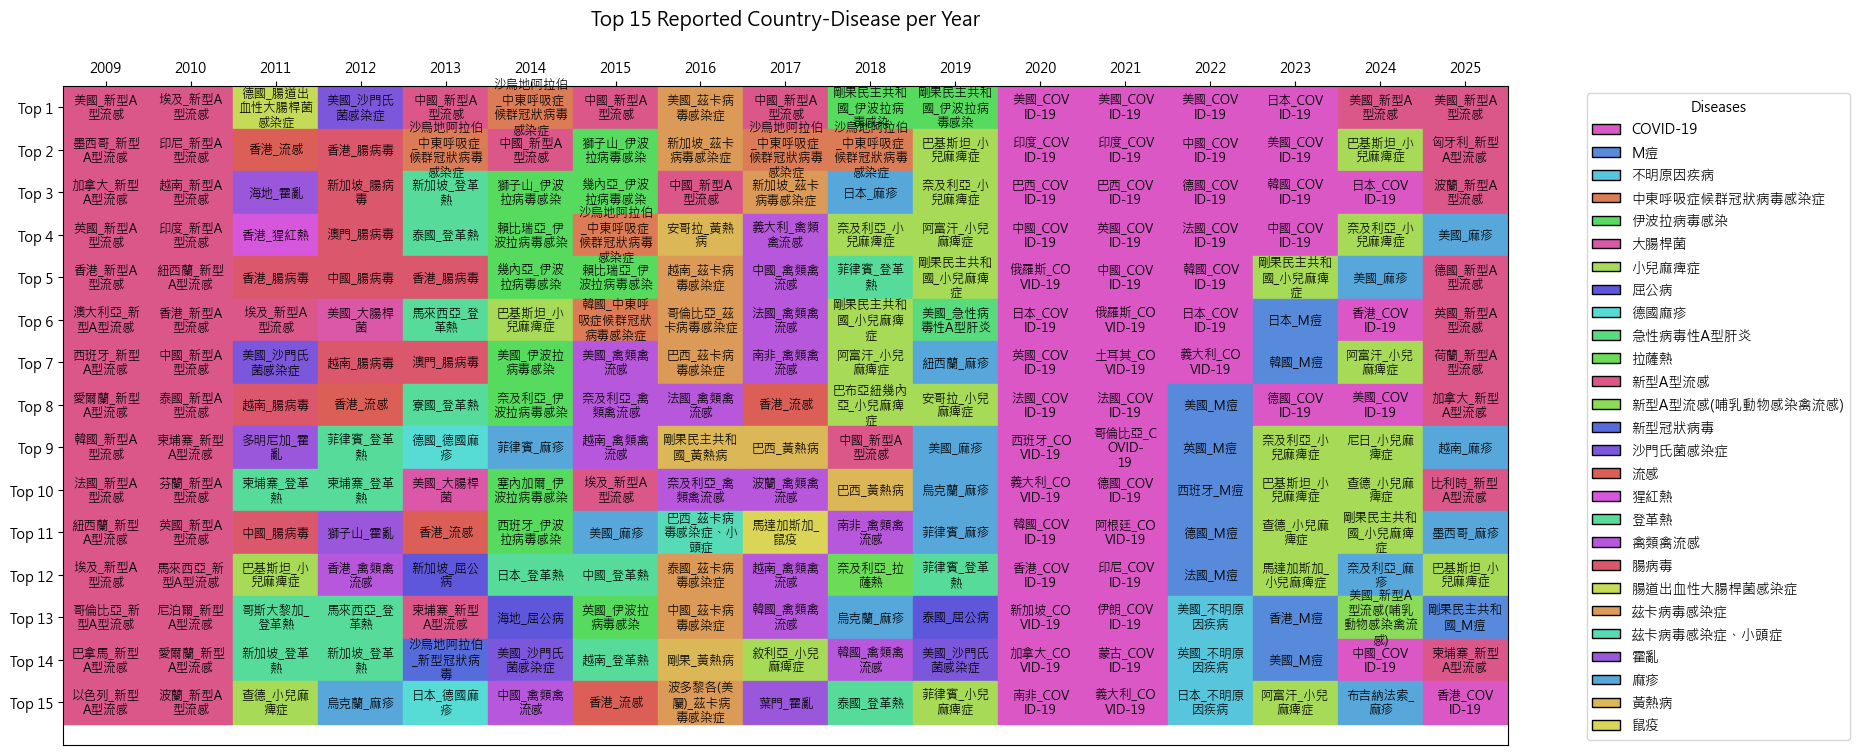

In [326]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import textwrap

# 🟢 Parameters
n_top_countries = 15

# 🟢 Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

# Group by year and country_disease, count occurrences
df_counts = (
    df_plot
    .groupby(['year', 'country_disease'])
    .size()
    .reset_index(name='count')
)

# Get top N per year
top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_disease']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_disease']],
    index=years
).T

# 🟢 Extract unique disease names from country_disease strings in top N
diseases_in_top = set()
for col in country_table.columns:
    for val in country_table[col]:
        if val:
            disease = val.split('_')[-1]
            diseases_in_top.add(disease)

# Generate color palette for these diseases
palette = sns.color_palette("hls", len(diseases_in_top))
disease_color_map = dict(zip(diseases_in_top, palette))

# 🟢 Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country_disease = country_table.iloc[row, col]
        
        if country_disease:
            # Extract disease_name from country_disease (split by "_")
            disease = country_disease.split('_')[-1]
            color = disease_color_map.get(disease, 'lightgray')
        else:
            color = 'lightgray'
        
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country_disease, width=6)) if country_disease else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# 🟢 Legend showing only disease names
legend_elements = [
    Patch(facecolor=disease_color_map[d], edgecolor='black', label=d)
    for d in sorted(diseases_in_top) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title(f"Top {n_top_countries} Reported Country-Disease per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()


# Variety

### 1. Diversity count (baseline)

In [10]:
variety_count = df.groupby(df['date'].dt.year)['country_disease'].nunique().reset_index()
variety_count.columns = ['year', 'unique_country_disease_count']
print(variety_count)


    year  unique_country_disease_count
0   2009                           798
1   2010                          1020
2   2011                          1105
3   2012                           917
4   2013                           751
5   2014                           646
6   2015                           646
7   2016                           694
8   2017                           605
9   2018                           490
10  2019                           603
11  2020                           554
12  2021                           574
13  2022                           730
14  2023                           764
15  2024                           804
16  2025                           429


## 2. Entropy

    year  shannon_entropy
0   2009             5.34
1   2010             5.83
2   2011             6.41
3   2012             6.21
4   2013             5.93
5   2014             5.48
6   2015             5.69
7   2016             5.75
8   2017             5.52
9   2018             5.52
10  2019             5.70
11  2020             4.94
12  2021             4.99
13  2022             5.16
14  2023             5.99
15  2024             6.14
16  2025             5.63


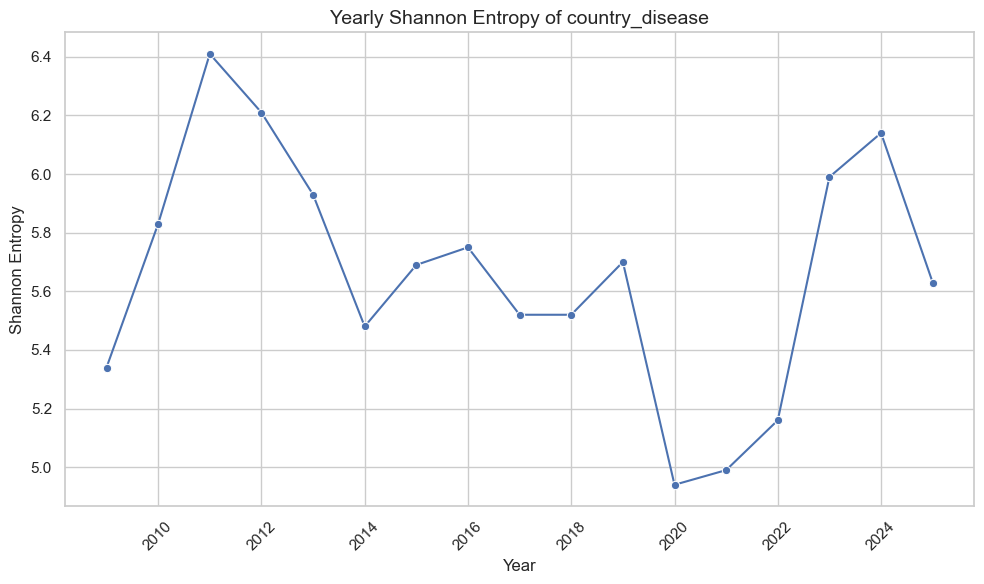

In [ ]:
import numpy as np

def shannon_entropy(x):
    counts = x.value_counts()
    proportions = counts / counts.sum()
    return -np.sum(proportions * np.log(proportions))

entropy = df.groupby(df['date'].dt.year)['country_disease'].apply(shannon_entropy).reset_index().round(2)
entropy.columns = ['year', 'shannon_entropy']
print(entropy)


import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your entropy dataframe is available
# entropy = ... (your existing calculation)

# Set seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10,6))
sns.lineplot(data=entropy, x='year', y='shannon_entropy', marker='o')

# Titles and labels
plt.title('Yearly Entropy of country-disease', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Shannon Entropy', fontsize=12)

# Optional: rotate x-axis labels if many years
plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()